In [1]:
import numpy as np
import pandas as pd
import os

In [314]:
categories = ['Airplane', 'Alarm', 'Beep/Bleep', 'Bell', 'Bicycle', 'Bird Chirp', 'Bus', 'Car', 'Cat Meow',
        'Chainsaw', 'Clapping', 'Cough', 'Cow Moo', 'Cowbell', 'Crying', 'Dog Bark', 'Doorbell', 'Drip',
        'Drums', 'Fire', 'Footsteps', 'Guitar', 'Hammer', 'Helicopter', 'Hiccup', 'Horn Honk', 'Horse Neigh',
        'Insect Buzz', 'Jackhammer', 'Laughter', 'Lawn Mower', 'Motorcycle', 'Piano', 'Pig Oink', 'Power Drill',
        'Power Saw', 'Rain', 'Rooster Crow', 'Saxophone', 'Sewing Machine', 'Sheep/Goat Bleat', 'Ship/Boat',
        'Shout', 'Singing', 'Siren', 'Sneeze', 'Snoring', 'Speech', 'Stream/River', 'Thunder', 'Train', 'Truck',
        'Trumpet', 'Vacuum Cleaner', 'Violin', 'Washing Machine', 'Waves', 'Wind']

features_dir = r"audio_features"
labels_dir = r"labels"

In [315]:
ann_df = pd.read_csv( 'annotations.csv')
meta_df = pd.read_csv('metadata.csv')


train_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[:int(len(meta_df)*0.7)]
validation_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.7):int(len(meta_df)*0.9)]
test_filename = meta_df.sample(len(meta_df),random_state=42)['filename'].unique()[int(len(meta_df)*0.9):len(meta_df)]

In [316]:
def aggregate_labels(file_labels):
    __y = []
    for frame_labels in file_labels:
        if(sum(frame_labels) == 0):
            __y.append([0])
        elif(np.count_nonzero(frame_labels) == len(frame_labels)):
             __y.append([1])
        else: #The annotators don't agree on the label
            __y.append([np.random.choice(frame_labels)])
    return __y

In [9]:
def read_file(model, file_name):
    X_train = []
    Y_train = {c: [] for c in categories}  # Initialize label dictionary

    for f in file_name:
        base = f.split('.')[0]
        feature_path = os.path.join(features_dir, base + '.npz')
        label_path = os.path.join(labels_dir, base + '_labels.npz')

        # Load feature(s)
        data = np.load(feature_path)
        if model == "tr":
            features = data["melspectrogram"]
        else:
            features_mel = data["melspectrogram"]
            features_mfcc = data["mfcc"]

            # Align on minimum length
            min_length = min(features_mel.shape[0], features_mfcc.shape[0])
            features_mel = features_mel[:min_length]
            features_mfcc = features_mfcc[:min_length]
            features = np.concatenate([features_mel, features_mfcc], axis=1)

        X_train.append(features)

        # Load and process labels
        y = np.load(label_path)
        for c in categories:
            _y = aggregate_labels(y[c])
            flat_labels = list(itertools.chain.from_iterable(_y))
            if model == "tr":
                Y_train[c].extend(flat_labels)
            else:
                Y_train[c].extend(flat_labels[:features.shape[0]])  # Trim to match feature length

    X_train = np.concatenate(X_train, axis=0)  # (total_frames, features)
    return X_train, Y_train


In [10]:
train_x_tr,train_y = read_file(model="tr",file_name=train_filename)
train_x_bi,train_y = read_file(model="bi",file_name=train_filename)

In [317]:
from sklearn.preprocessing import StandardScaler

def log_scalling(array):
    epsilon = 1e-10  
    log_array = np.log(array + epsilon)
    return log_array
    
def z_score(array):
    s = StandardScaler()
    scaled_array = s.fit_transform(array)
    return scaled_array,s.mean_,s.scale_

In [318]:
scaled_train_x_tr ,mu_tr,std_tr  = z_score(train_x_tr)
scaled_train_x_bi ,mu_bi,std_bi  = z_score(train_x_bi)

In [ ]:
test_filename

In [207]:
#ann_df["test_Set"] = ann_df["filename"].isin(test_filename)
#ann_df.set_index("filename")
#ann_df[ann_df["test_Set"] == True].iloc[200:220]  

In [346]:
ann_df[ann_df["filename"].isin(["114463.mp3"])]

,task_id,filename,annotator,text,onset,offset,time,original_caption,categories
26661,161992073,114463.mp3,1004254503179064963908953886232305308692284968...,A group of people walking and speaking.,4.862593,22.759,170.348,Group of people walking and speaking clearly,"['Footsteps', 'Speech']"
26662,161992073,114463.mp3,1004254503179064963908953886232305308692284968...,A railroad bell rings with a constant metallic...,0.010412,22.759,170.348,Working railroad bell with metallic constant s...,['Bell']


In [320]:
#406542.mp3 519052: birds+dog in bg; 666881

In [333]:
x1_bi, y1_bi = read_file("bi",['650520.mp3']) #DONT TOUCH THISSSSS
x2_bi, y2_bi = read_file("bi",['114463.mp3'])

In [334]:
x1_bi.shape

(129, 96)

In [335]:
scaled_x1 = ((x1_bi) - mu_bi)/std_bi
scaled_x2 = ((x2_bi) - mu_bi)/std_bi

In [336]:

y1_labels = np.array([y1_bi[cls] for cls in categories]).T
y2_labels = np.array([y2_bi[cls] for cls in categories]).T


In [337]:
import torch.nn as nn
class SpectrogramTransformer(nn.Module):
    def __init__(self,mel_bin=64,em_dim=128,num_labels=58 , n_head=4 , num_layer=2,dropout=0.3):
        super().__init__()
        self.input_projection = nn.Linear(mel_bin,em_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=em_dim,nhead=n_head,dropout=dropout,batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer,num_layer)
        self.classifier = nn.Linear(em_dim,num_labels)

    def forward(self,x):
        x = self.input_projection(x)
        x = self.transformer(x)
        logits = self.classifier(x)
        return logits



class LSTMAED(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=2, dropout=0.3,bidirectional=False):
        super(LSTMAED, self).__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout
        )
        if bidirectional is True:
            linear= nn.Linear(hidden_dim * 2, num_classes)
        else:
            linear= nn.Linear(hidden_dim, num_classes)
        self.classifier = nn.Sequential( linear)

    def forward(self, x):
        lstm_out, _ = self.bilstm(x)  
        out = self.classifier(lstm_out)  
        return out

In [338]:
import torch
tr = SpectrogramTransformer(em_dim=32).to("cuda")
bi = LSTMAED(96,128,58,bidirectional=True)
tr.load_state_dict(torch.load('spectrogram_transformer32_weights.pth', weights_only=True))
bi.load_state_dict(torch.load("BiLSTM_weights.pth",weights_only=True))
tr.eval()
bi.eval()

LSTMAED(
  (bilstm): LSTM(96, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=58, bias=True)
  )
)

In [339]:
x1_tr_tensor = torch.tensor(logscaled_x1)
x1_bi_tensor=torch.tensor(scaled_x1)
y1_tensor=torch.tensor(y1_labels)

x2_tr_tensor = torch.tensor(logscaled_x2)
x2_bi_tensor = torch.tensor(scaled_x2)
y2_tensor = torch.tensor(y2_labels)

In [340]:
from torch.utils.data import DataLoader, TensorDataset



x1_bi_dataset = TensorDataset(x1_bi_tensor,y1_tensor)
x2_bi_dataset = TensorDataset(x2_bi_tensor,y2_tensor)



x1_bi_loader = DataLoader(x1_bi_dataset,32)
x2_bi_loader = DataLoader(x2_bi_dataset,32)


In [375]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # You can keep F.sigmoid if you prefer

def predict(model, loader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    all_preds = []
    all_targets = []
    loss = []
    criterion = nn.BCEWithLogitsLoss()

    with torch.no_grad():
        val_loss = 0.0
        for x, y in loader:
            x = x.float().to(device)
            y = y.float().to(device)
            val_output = model(x)
            val_loss += criterion(val_output, y).item()

            probs = torch.sigmoid(val_output)
            preds = (probs > 0.5).int()
            targets = y.int()

            all_preds.append(preds)
            all_targets.append(targets)

        avg_val_loss = val_loss / len(loader)
        loss.append(avg_val_loss)

        # Stack predictions
        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        # Compute metrics
        TP = (all_preds & all_targets).sum(dim=0).float()
        FP = ((all_preds == 1) & (all_targets == 0)).sum(dim=0).float()
        FN = ((all_preds == 0) & (all_targets == 1)).sum(dim=0).float()
        TN = ((all_preds == 0) & (all_targets == 0)).sum(dim=0).float()

        precision = TP / (TP + FP + 1e-8)
        recall = TP / (TP + FN + 1e-8)
        f1 = (2 * precision * recall) / (precision + recall + 1e-8)
        tnr = TN / (TN + FP + 1e-8)
        balanced_acc = (recall + tnr) / 2

        avg_precision = precision.mean().item()
        avg_recall = recall.mean().item()
        avg_f1 = f1.mean().item()
        avg_bal_acc = balanced_acc.mean().item()
        val_accuracy = (all_preds == all_targets).float().mean().item()

        print(f"Val Loss:                    {avg_val_loss:.4f}")
        print(f"Validation Accuracy:         {val_accuracy:.4f}")
        print(f"Precision:                   {avg_precision:.4f}")
        print(f"Recall:                      {avg_recall:.4f}")
        print(f"F1 Score:                    {avg_f1:.4f}")
        print(f"Average Balanced Accuracy:   {avg_bal_acc:.4f}")

        return all_preds, all_targets


In [376]:
x2_bi_pred ,x2_targets = predict(bi,x2_bi_loader)
x1_bi_pred,x1_targets = predict(bi,x1_bi_loader)

Val Loss:                    0.2037
Validation Accuracy:         0.9471
Precision:                   0.0345
Recall:                      0.0010
F1 Score:                    0.0018
Average Balanced Accuracy:   0.4872
Val Loss:                    0.0267
Validation Accuracy:         0.9922
Precision:                   0.0172
Recall:                      0.0136
F1 Score:                    0.0152
Average Balanced Accuracy:   0.4961


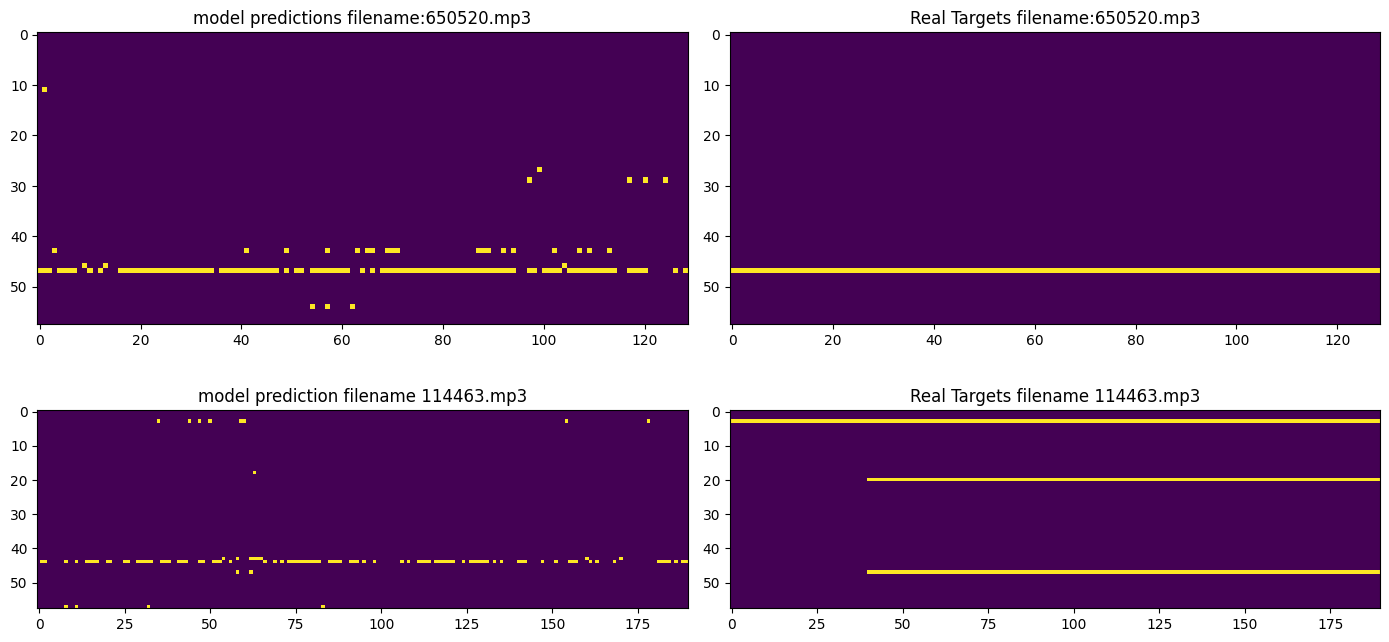

In [377]:
import seaborn as sns
fig,ax=plt.subplots(2,2,figsize=(14,7))
ax[0,0].imshow(x1_bi_pred.cpu().T)
ax[0,1].imshow(x1_targets.cpu().T)
ax[0,0].set_title("model predictions filename:650520.mp3")
ax[0,1].set_title("Real Targets filename:650520.mp3")

ax[1,0].imshow(x2_bi_pred.cpu().T)
ax[1,1].imshow(x2_targets.cpu().T)
ax[1,0].set_title("model prediction filename 114463.mp3")
ax[1,1].set_title("Real Targets filename 114463.mp3")
plt.tight_layout()

c) the audio file 650520 was on;y labeled with class speech although it contained laughter which the model recognized and predicted as such which decreases the balanced accuracy 
evidence:
student annotation: A person is speaking humorously into a microph.
llm mapped label :Speech ONLY

the audio file 114463 contained very high frequency beeping sound throughout the entire audio file with some speech and laughter spread out ,
the og labels extrtactyed from the annotation by the lmm were where bell ,speech , and footsteps ---> our  model predicted siren instead of beep/bleep but barely registered the speech. -> coz high frequency + shitty class categorisation coz potential overalp bw label(thats what karim thiinks i swear) eg:siren vs beep/bleep vs bell



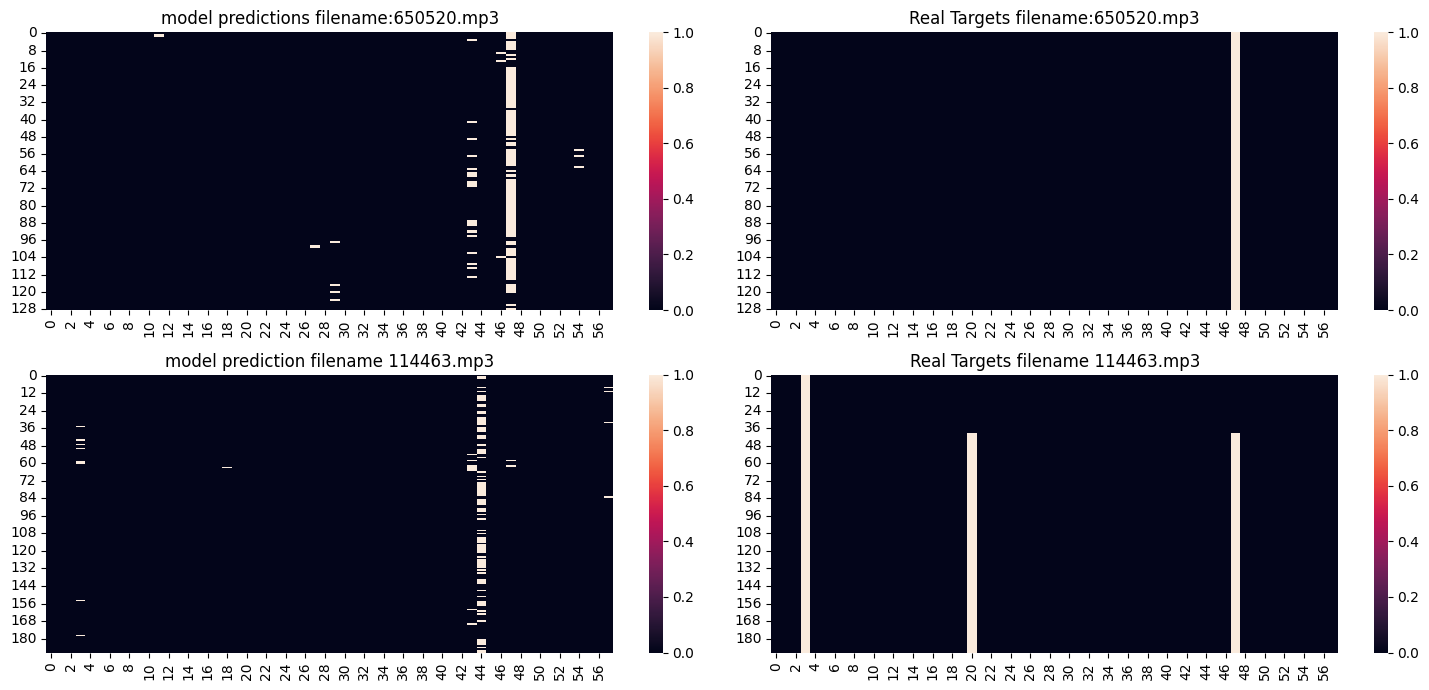

In [378]:
fig,ax =plt.subplots(2,2,figsize=(15,7))
sns.heatmap(x1_bi_pred.cpu(),ax=ax[0,0])
sns.heatmap(x1_targets.cpu(),ax=ax[0,1])
sns.heatmap(x2_bi_pred.cpu(),ax=ax[1,0])
sns.heatmap(x2_targets.cpu(),ax=ax[1,1])
ax[0,0].set_title("model predictions filename:650520.mp3")
ax[0,1].set_title("Real Targets filename:650520.mp3")
ax[1,0].set_title("model prediction filename 114463.mp3")
ax[1,1].set_title("Real Targets filename 114463.mp3")

plt.tight_layout()